# LangChain Expression Language(LCEL)
- Code 출처 : https://python.langchain.com/docs/expression_language/
- 수정사항 : 설명문을 한글로 번역 

### Basic example: prompt + model + output parser
- LCEL을 사용하여 서로 다른 컴포넌트를 하나의 체인으로 연결합니다.
- | 기호는 유닉스 파이프 연산자와 유사하며, 한 컴포넌트의 출력을 다음 컴포넌트에 입력으로 공급하여 여러 컴포넌트를 체인으로 연결합니다.

In [1]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

prompt = ChatPromptTemplate.from_template("tell me a short joke about {topic}")
model = ChatOpenAI(model="gpt-3.5-turbo")
output_parser = StrOutputParser()

chain = prompt | model | output_parser

chain.invoke({"topic": "ice cream"})

'Why did the ice cream truck break down? It had too many "scoops"!'

### 1. Prompt
- prompt 는 템플릿 변수의 딕셔너리를 받아 PromptValue를 생성하는 BasePromptTemplate입니다. 
- PromptValue는 완성된 프롬프트를 감싸는 래퍼로, String을 입력으로 받는 LLM이나 Message 시퀀스를 입력으로 받는 ChatModel에 전달할 수 있습니다.  
- 이 래퍼는 BaseMessage를 생성하고 문자열을 생성하기 위한 로직을 정의하므로 두 언어 모델유형 모두에서 작동할 수 있습니다.

In [2]:
prompt_value = prompt.invoke({"topic": "ice cream"})
prompt_value

ChatPromptValue(messages=[HumanMessage(content='tell me a short joke about ice cream')])

In [3]:
prompt_value.to_messages()

[HumanMessage(content='tell me a short joke about ice cream')]

In [4]:
prompt_value.to_string()

'Human: tell me a short joke about ice cream'

### 2. Model
- PromptValue를 model에 전달합니다.  
- 이 경우 model은 ChatModel 이므로 BaseMessage를 출력합니다.

In [5]:
message = model.invoke(prompt_value)
message

AIMessage(content='Why did the ice cream truck break down? Because it had too many "scoops"!')

model이 LLM이면 문자열을 출력합니다.

In [6]:
from langchain_openai.llms import OpenAI

llm = OpenAI(model="gpt-3.5-turbo-instruct")
llm.invoke(prompt_value)

'\n\nWhy did the ice cream go to therapy? Because it was feeling a little melon-choly.'

### 3. Output parser
- 마지막으로 model 출력을 output_parser에 전달하는데, 이 output_parser는 문자열 또는 BaseMessage를 입력으로 받는다는 의미의 BaseOutputParser입니다.
- StrOutputParser는 모든 입력을 문자열로 간단하게 변환합니다.

In [7]:
output_parser.invoke(message)

'Why did the ice cream truck break down? Because it had too many "scoops"!'

### 4. Entire Pipeline
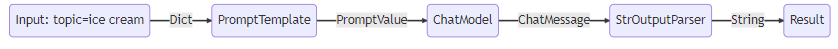

In [8]:
input = {"topic": "ice cream"}

In [9]:
prompt.invoke(input)

ChatPromptValue(messages=[HumanMessage(content='tell me a short joke about ice cream')])

In [10]:
(prompt | model).invoke(input)

AIMessage(content='Why did the ice cream go to therapy? Because it had too many sprinkles of emotional baggage!')

### 5. RAG Search Example
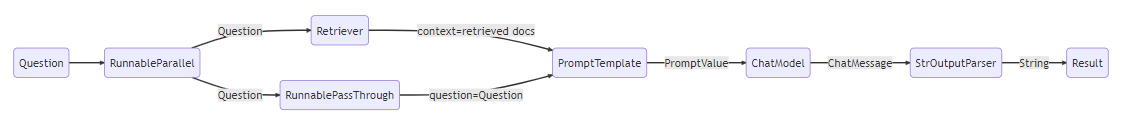

In [11]:
%pip install docarray

  Using cached docarray-0.40.0-py3-none-any.whl.metadata (36 kB)
  Using cached rich-13.7.0-py3-none-any.whl.metadata (18 kB)
  Using cached markdown_it_py-3.0.0-py3-none-any.whl.metadata (6.9 kB)
Using cached docarray-0.40.0-py3-none-any.whl (270 kB)
Using cached rich-13.7.0-py3-none-any.whl (240 kB)
Using cached markdown_it_py-3.0.0-py3-none-any.whl (87 kB)
Using cached mdurl-0.1.2-py3-none-any.whl (10.0 kB)
Note: you may need to restart the kernel to use updated packages.


In [12]:
# Requires:
# pip install langchain docarray tiktoken

from langchain_community.vectorstores import DocArrayInMemorySearch
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnableParallel, RunnablePassthrough
from langchain_openai.chat_models import ChatOpenAI
from langchain_openai.embeddings import OpenAIEmbeddings

vectorstore = DocArrayInMemorySearch.from_texts(
    ["harrison worked at kensho", "bears like to eat honey"],
    embedding=OpenAIEmbeddings(),
)
retriever = vectorstore.as_retriever()

template = """Answer the question based only on the following context:
{context}

Question: {question}
"""
prompt = ChatPromptTemplate.from_template(template)
model = ChatOpenAI()
output_parser = StrOutputParser()

setup_and_retrieval = RunnableParallel(
    {"context": retriever, "question": RunnablePassthrough()}
)
chain = setup_and_retrieval | prompt | model | output_parser

chain.invoke("where did harrison work?")

D:\강의자료\생성형AI로AI애플리케이션개발하기\py311\Lib\site-packages\pydantic\_migration.py:283: UserWarning: `pydantic.error_wrappers:ValidationError` has been moved to `pydantic:ValidationError`.
  warnings.warn(f'`{import_path}` has been moved to `{new_location}`.')


ValidationError: 2 validation errors for DocArrayDoc
text
  Field required [type=missing, input_value={'embedding': [-0.0191128..., 0.010052215411752113]}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.6/v/missing
metadata
  Field required [type=missing, input_value={'embedding': [-0.0191128..., 0.010052215411752113]}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.6/v/missing

### Interface

In [28]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

model = ChatOpenAI()
prompt = ChatPromptTemplate.from_template("tell me a joke about {topic}")
chain = prompt | model

In [29]:
chain.input_schema.schema()

{'title': 'PromptInput',
 'type': 'object',
 'properties': {'topic': {'title': 'Topic', 'type': 'string'}}}

In [30]:
prompt.input_schema.schema()

{'title': 'PromptInput',
 'type': 'object',
 'properties': {'topic': {'title': 'Topic', 'type': 'string'}}}

In [32]:
model.input_schema.schema()

{'title': 'ChatOpenAIInput',
 'anyOf': [{'type': 'string'},
  {'$ref': '#/definitions/StringPromptValue'},
  {'$ref': '#/definitions/ChatPromptValueConcrete'},
  {'type': 'array',
   'items': {'anyOf': [{'$ref': '#/definitions/AIMessage'},
     {'$ref': '#/definitions/HumanMessage'},
     {'$ref': '#/definitions/ChatMessage'},
     {'$ref': '#/definitions/SystemMessage'},
     {'$ref': '#/definitions/FunctionMessage'},
     {'$ref': '#/definitions/ToolMessage'}]}}],
 'definitions': {'StringPromptValue': {'title': 'StringPromptValue',
   'description': 'String prompt value.',
   'type': 'object',
   'properties': {'text': {'title': 'Text', 'type': 'string'},
    'type': {'title': 'Type',
     'default': 'StringPromptValue',
     'enum': ['StringPromptValue'],
     'type': 'string'}},
   'required': ['text']},
  'AIMessage': {'title': 'AIMessage',
   'description': 'A Message from an AI.',
   'type': 'object',
   'properties': {'content': {'title': 'Content',
     'anyOf': [{'type': 'str

In [33]:
chain.output_schema.schema()

{'title': 'ChatOpenAIOutput',
 'anyOf': [{'$ref': '#/definitions/AIMessage'},
  {'$ref': '#/definitions/HumanMessage'},
  {'$ref': '#/definitions/ChatMessage'},
  {'$ref': '#/definitions/SystemMessage'},
  {'$ref': '#/definitions/FunctionMessage'},
  {'$ref': '#/definitions/ToolMessage'}],
 'definitions': {'AIMessage': {'title': 'AIMessage',
   'description': 'A Message from an AI.',
   'type': 'object',
   'properties': {'content': {'title': 'Content',
     'anyOf': [{'type': 'string'},
      {'type': 'array',
       'items': {'anyOf': [{'type': 'string'}, {'type': 'object'}]}}]},
    'additional_kwargs': {'title': 'Additional Kwargs', 'type': 'object'},
    'type': {'title': 'Type',
     'default': 'ai',
     'enum': ['ai'],
     'type': 'string'},
    'example': {'title': 'Example', 'default': False, 'type': 'boolean'}},
   'required': ['content']},
  'HumanMessage': {'title': 'HumanMessage',
   'description': 'A Message from a human.',
   'type': 'object',
   'properties': {'conten

In [34]:
for s in chain.stream({"topic": "bears"}):
    print(s.content, end="", flush=True)

Why don't bears like fast food?

Because they can't catch it!

In [35]:
chain.invoke({"topic": "bears"})

AIMessage(content="Why don't bears wear shoes?\n\nBecause they have bear feet!")

In [36]:
chain.batch([{"topic": "bears"}, {"topic": "cats"}])

[AIMessage(content="Why don't bears wear shoes?\n\nBecause they have bear feet!"),
 AIMessage(content="Why don't cats play poker in the wild? Too many cheetahs!")]

In [37]:
async for s in chain.astream({"topic": "bears"}):
    print(s.content, end="", flush=True)

Why don't bears wear shoes?

Because they already have bear feet!

In [38]:
await chain.ainvoke({"topic": "bears"})

AIMessage(content="Why don't bears ever wear shoes?\n\nBecause they have bear feet!")

In [39]:
await chain.abatch([{"topic": "bears"}])

[AIMessage(content="Why don't bears wear shoes?\n\nBecause they have bear feet!")]